In [30]:
import os
import numpy as np
import pandas as pd
import time
import warnings
from matplotlib import pyplot as plt

from sklearn.neural_network import MLPClassifier
import sklearn.metrics
from sklearn.metrics import balanced_accuracy_score

from sklearn.metrics import confusion_matrix
import seaborn as sns


## Loading Data

Contents of train_x.csv: arr of shape (2102, 784)
Contents of valid_x.csv: arr of shape (600, 784)


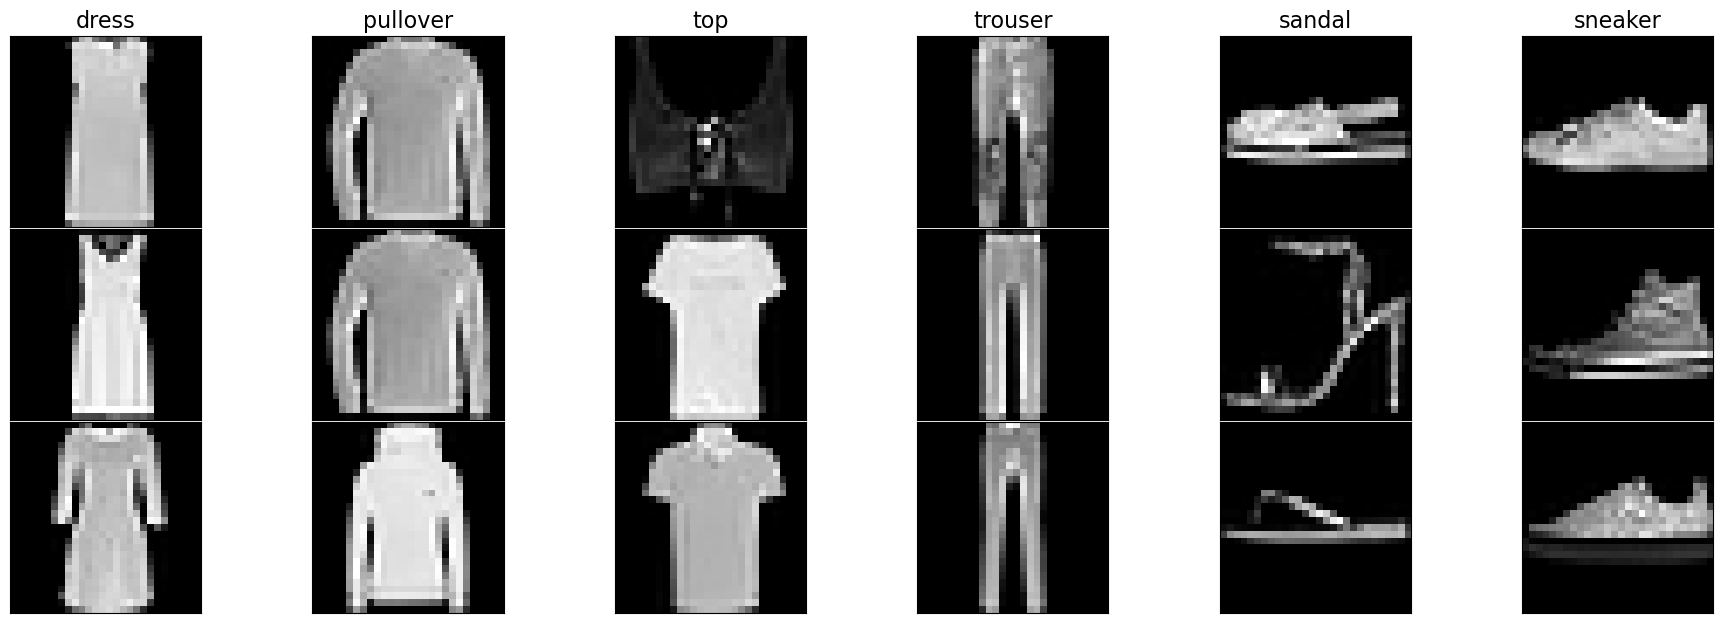

In [31]:
%run load_and_plot_data.py

In [32]:
train_y = np.array(train_y_df['class_uid'])
valid_y = np.array(valid_y_df['class_uid'])
train_x = train_x
valid_x = valid_x
train_y.shape, valid_y.shape

((2102,), (600,))

In [33]:
train_x.shape, train_x[0].dtype

((2102, 784), dtype('int64'))

In [34]:
# selecting the tops and trousers
top_x = train_x[train_y == 0]
trouser_x = train_x[train_y == 1]
top_y = train_y[train_y == 0]
trouser_y = train_y[train_y == 1]

print(top_x.shape, trouser_x.shape)
print(top_y.shape, trouser_y.shape)
# selecting the dresses
dress_x = train_x[train_y == 3]
dress_y = train_y[train_y == 3]
# selecting pullovers
pullover_x = train_x[train_y == 2]
pullover_y = train_y[train_y == 2]

(1, 784) (1, 784)
(1,) (1,)


In [35]:
# duplicated top and trouser arrays
top_x_array = np.tile(top_x, (799, 1))
trouser_x_array = np.tile(trouser_x, (799, 1))

top_y_array = np.tile(top_y, (799))
trouser_y_array = np.tile(trouser_y, (799))

print(top_x_array.shape, trouser_x_array.shape)
print(top_y_array.shape, trouser_y_array.shape)

(799, 784) (799, 784)
(799,) (799,)


In [36]:
#### duplicating tops/trousers
# duplicated top and trouser arrays
top_x_array = np.tile(top_x, (799, 1))
trouser_x_array = np.tile(trouser_x, (799, 1))

top_y_array = np.tile(top_y, (799))
trouser_y_array = np.tile(trouser_y, (799))

print(top_x_array.shape, trouser_x_array.shape)
print(top_y_array.shape, trouser_y_array.shape)
#### Randomly Duplicating
#randomly duplicating dresses
dress_dupe_in = np.random.choice(len(dress_x), size = 400, replace = True)
dress_dupe_x = dress_x[dress_dupe_in]
dress_dupe_y = dress_y[dress_dupe_in]
dress_x_array = dress_dupe_x
dress_y_array = dress_dupe_y
#randomly duplicating pullovers 
pull_dupe_in = np.random.choice(len(pullover_x), size = 700, replace = True)
#print(dress_duplicates_in)
pull_dupe_x = pullover_x[pull_dupe_in]
pull_dupe_y = pullover_y[pull_dupe_in]
#count = np.unique(dress_duplicates_x, return_counts = True)
#count
pullover_x_array = pull_dupe_x
pullover_y_array = pull_dupe_y
## Adding tops, trousers, and dresses to train_x
temp = np.vstack((train_x, top_x_array))
print(temp.shape)

temp2 = np.vstack((temp, dress_x_array))
print(temp2.shape)

temp3 = np.vstack((temp2, pullover_x_array))
print(temp3.shape)

duplicated_train_x = np.vstack((temp3, trouser_x_array))
print(duplicated_train_x.shape)


t = np.hstack((train_y, top_y_array))
t2 = np.hstack((t, dress_y_array))
t3 = np.hstack((t2, pullover_y_array))
duplicated_train_y = np.hstack((t3, trouser_y_array))
print(top_y_array.shape, dress_y_array.shape, trouser_y_array.shape, pullover_y_array.shape)

print(duplicated_train_x.shape, duplicated_train_y.shape)
valid_y = np.array(valid_y_df['class_uid'])
valid_y.shape, duplicated_train_y.shape


(799, 784) (799, 784)
(799,) (799,)
(2901, 784)
(3301, 784)
(4001, 784)
(4800, 784)
(799,) (400,) (799,) (700,)
(4800, 784) (4800,)


((600,), (4800,))

## Data Proprocessing with Normalization

In [37]:
normed_train_x = sklearn.preprocessing.normalize(duplicated_train_x, norm = 'l1', axis = 1)
normed_valid_x = sklearn.preprocessing.normalize(valid_x, norm = 'l1', axis = 1)


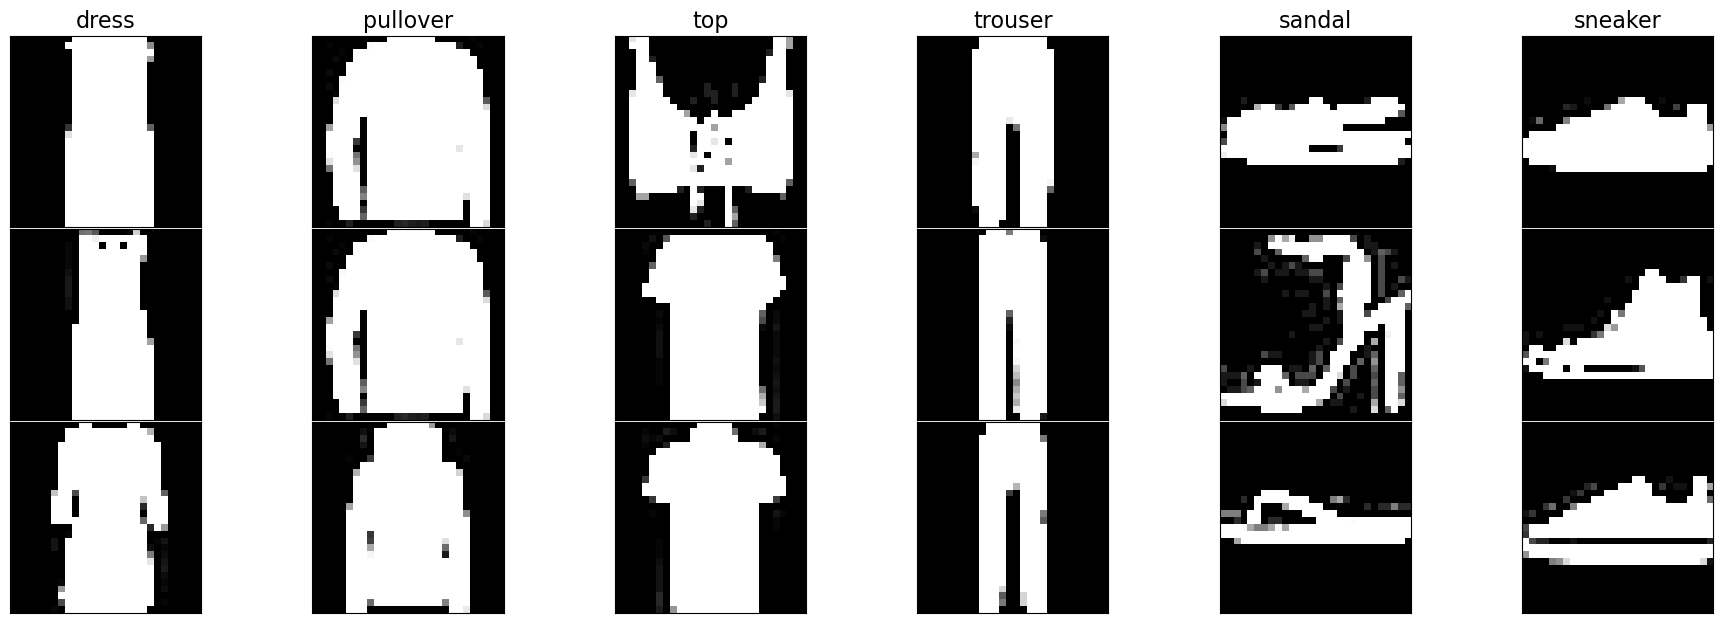

In [38]:
prng = np.random.RandomState(0)
N = 3 # num examples of each class to show
fig, axgrid = plt.subplots(N, 6, figsize=(6*3, N*2.5))

for ll, label in enumerate(['dress', 'pullover', 'top', 'trouser', 'sandal', 'sneaker']):
    match_df = valid_y_df.query("class_name == '%s'" % label)
    match_ids_N = prng.choice(match_df.index, size=N)        
    for ii, row_id in enumerate(match_ids_N):
        ax = axgrid[ii, ll]
        x_SS = normed_valid_x[row_id].reshape((28,28))
        ax.imshow(x_SS, vmin=0, vmax=255/normed_valid_x.shape[0]/normed_valid_x[0].shape[0], cmap='gray')
        ax.set_xticks([]); ax.set_yticks([]);
        if ii == 0:
            ax.set_title(label, fontsize=16)
plt.subplots_adjust(left=0.01, right=0.99, wspace=.2, hspace=.01)
#plt.tight_layout();
plt.show();

## Data Augmentation

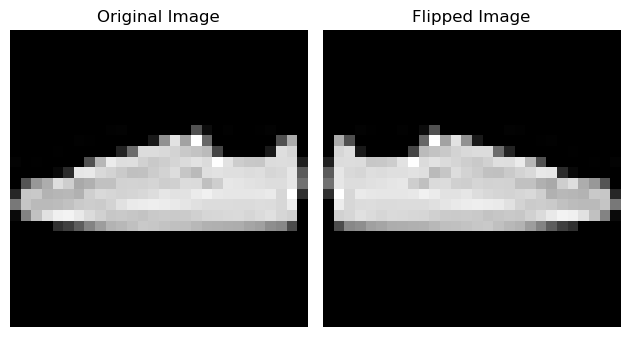

(5300, 784)

In [64]:
## Horizontal Flip
num_rows_to_flip = 200

# Generate random indices to select rows for flipping
selected_indices_tr = np.random.choice(normed_train_x.shape[0], num_rows_to_flip, replace=False)
aug_tr = np.copy(normed_train_x)

aug_tr_reshaped = aug_tr.reshape(-1, 28, 28)
aug_tr_reshaped[selected_indices_tr] = np.flip(aug_tr_reshaped[selected_indices_tr], axis=2)
aug_tr_flattened = aug_tr_reshaped.reshape(-1, 784)

if not np.isclose(np.sum(aug_tr[selected_indices_tr[0]]), np.sum(normed_train_x[selected_indices_tr[0]]), atol = 1e-8):
    warnings.warn('Flip Failed!')
    
plt.subplot(1, 2, 1)
plt.imshow(normed_train_x[selected_indices_tr[0]].reshape(28,28), cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(aug_tr[selected_indices_tr[0]].reshape(28,28), cmap='gray')
plt.title('Flipped Image')
plt.axis('off')

plt.tight_layout()
plt.show()

new_tr_x = aug_tr_flattened[selected_indices_tr]
normed_train_x = np.concatenate((normed_train_x, new_tr_x),axis = 0)
new_tr_y = duplicated_train_y[selected_indices_tr]
duplicated_train_y = np.concatenate((duplicated_train_y,new_tr_y), axis = 0)
normed_train_x.shape

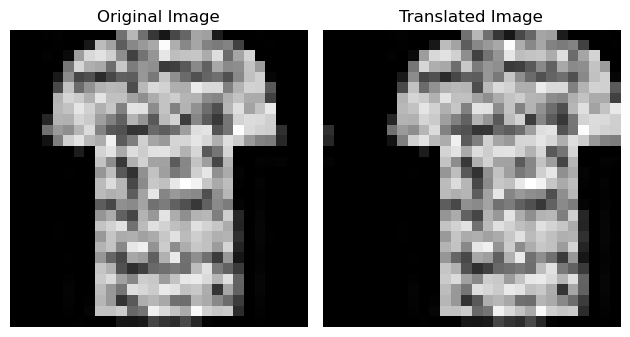

In [65]:
## Translation
translation_amount = 3  # Adjust the amount of translation
aug_tr = np.copy(normed_train_x)
num_images_to_translate = 400

selected_indices_tr = np.random.choice(normed_train_x.shape[0], num_images_to_translate, replace=False)
aug_tr = np.copy(normed_train_x)
aug_tr_reshaped = aug_tr.reshape(-1, 28, 28)
aug_tr_reshaped[selected_indices_tr] = np.roll(aug_tr_reshaped[selected_indices_tr], translation_amount, axis=2)
aug_tr_flattened = aug_tr_reshaped.reshape(-1, 784)

plt.subplot(1, 2, 1)
plt.imshow(normed_train_x[selected_indices_tr[0]].reshape(28,28), cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(aug_tr[selected_indices_tr[0]].reshape(28,28), cmap='gray')
plt.title('Translated Image')
plt.axis('off')

plt.tight_layout()
plt.show()

# normed_train_x = aug_tr_flattened
# duplicated_train_y = np.concatenate((duplicated_train_y,duplicated_train_y[selected_indices]))
# normed_train_x = np.concatenate((aug_tr,aug_tr_flattened[selected_indices]),axis =0)


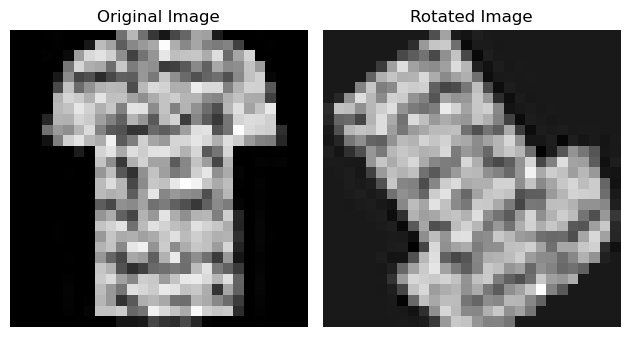

(5500, 784)

In [66]:
## Rotation
from scipy.ndimage import rotate

aug_tr = np.copy(normed_train_x)
num_rows_to_rotate = 200 # max = 2102

selected_indices = np.random.choice(aug_tr.shape[0], num_rows_to_rotate, replace=False)
rotated_array = np.copy(aug_tr)

for row in selected_indices:
    # Randomly rotate elements within the row
    random_angle = np.random.randint(30, 300)  # Choose a random angle between 0 and 360 degrees
    rotated_array[row] = rotate(rotated_array[row].reshape(28,28), random_angle, reshape=False).reshape(784,)
    


plt.subplot(1, 2, 1)
plt.imshow(normed_train_x[selected_indices[0]].reshape(28,28), cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(rotated_array[selected_indices[0]].reshape(28,28), cmap='gray')
plt.title('Rotated Image')
plt.axis('off')

plt.tight_layout()
plt.show()


duplicated_train_y = np.concatenate((duplicated_train_y,duplicated_train_y[selected_indices]))
normed_train_x = np.concatenate((aug_tr,rotated_array[selected_indices]),axis =0)
normed_train_x.shape

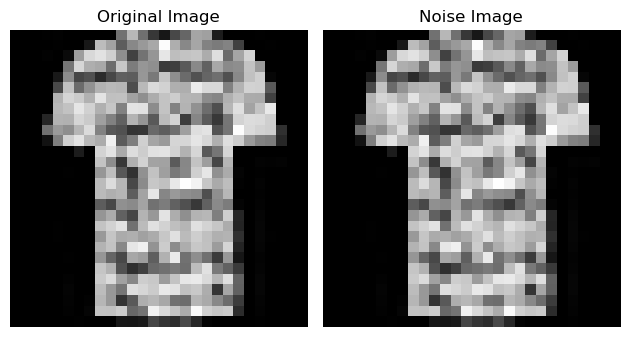

(5600, 784)

In [67]:
min_range, max_range = -0.8, 0.8
num_images_to_translate = 100  
num_points_to_translate = 50


num_images = normed_train_x.shape[0]
random_indices = np.random.choice(num_images, num_images_to_translate, replace=False)

mod_data = np.copy(normed_train_x)
for i in random_indices:
    indices = np.random.choice(mod_data.shape[1], num_points_to_translate, replace = False)
    mod_data[i] += np.random.uniform(min_range, max_range, size = mod_data.shape[1])
    mod_data[i] = np.clip(mod_data[i], 0.0, 1.0)

plt.subplot(1, 2, 1)
plt.imshow(normed_train_x[selected_indices[0]].reshape(28,28), cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(mod_data[selected_indices[0]].reshape(28,28), cmap='gray')
plt.title('Noise Image')
plt.axis('off')

plt.tight_layout()
plt.show()

normed_train_x = np.vstack((normed_train_x, mod_data[random_indices]))
duplicated_train_y = np.hstack((duplicated_train_y, duplicated_train_y[random_indices]))
normed_train_x.shape


In [71]:
n = 8
random_states = np.random.randint(1, 1000, size=n)

In [72]:
mlp = MLPClassifier(
            solver='lbfgs',
            # batch_size=200,
            n_iter_no_change = 20
            )

In [73]:
random_states

array([216, 823, 737, 137, 988, 185, 731, 231])

In [75]:
mlp_hyperparameter_grid = dict(
    activation = ['relu'],
    hidden_layer_sizes = [(50,)],  
    max_iter = [300],
    random_state = random_states,
    alpha = np.logspace(2, -7, 9),
    n_iter_no_change = [25]
)

# Hyperparameter Search

In [76]:
xall = np.vstack([normed_train_x, normed_valid_x])
yall = np.hstack([duplicated_train_y, valid_y])

### splitter
valid_indicators_L = np.hstack([
    -1 * np.ones(duplicated_train_y.size), # -1 means never include this example in any test split
    0  * np.ones(valid_y.size), #  0 means include in the first test split (we count starting at 0 in python)
    ])
my_splitter = sklearn.model_selection.PredefinedSplit(valid_indicators_L)

In [77]:
mlp_searcher = sklearn.model_selection.GridSearchCV(estimator = mlp,
                                                    param_grid = mlp_hyperparameter_grid,
                                                    scoring = 'balanced_accuracy',
                                                    cv = my_splitter,
                                                    return_train_score = True,
                                                    refit=False, verbose = 5
                                                   )

In [78]:
start_time_sec = time.time()
mlp_searcher.fit(xall, yall)
elapsed_time_sec = time.time() - start_time_sec

Fitting 1 folds for each of 72 candidates, totalling 72 fits
[CV 1/1] END activation=relu, alpha=100.0, hidden_layer_sizes=(50,), max_iter=300, n_iter_no_change=25, random_state=216;, score=(train=0.168, test=0.167) total time=   3.1s
[CV 1/1] END activation=relu, alpha=100.0, hidden_layer_sizes=(50,), max_iter=300, n_iter_no_change=25, random_state=823;, score=(train=0.172, test=0.167) total time=   3.1s
[CV 1/1] END activation=relu, alpha=100.0, hidden_layer_sizes=(50,), max_iter=300, n_iter_no_change=25, random_state=737;, score=(train=0.168, test=0.167) total time=   1.7s
[CV 1/1] END activation=relu, alpha=100.0, hidden_layer_sizes=(50,), max_iter=300, n_iter_no_change=25, random_state=137;, score=(train=0.168, test=0.167) total time=   2.2s
[CV 1/1] END activation=relu, alpha=100.0, hidden_layer_sizes=(50,), max_iter=300, n_iter_no_change=25, random_state=988;, score=(train=0.167, test=0.167) total time=   4.4s
[CV 1/1] END activation=relu, alpha=100.0, hidden_layer_sizes=(50,), 

/Users/richardwang/micromamba/envs/cs135_env/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/1] END activation=relu, alpha=7.498942093324558, hidden_layer_sizes=(50,), max_iter=300, n_iter_no_change=25, random_state=216;, score=(train=0.873, test=0.845) total time=  29.2s


/Users/richardwang/micromamba/envs/cs135_env/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/1] END activation=relu, alpha=7.498942093324558, hidden_layer_sizes=(50,), max_iter=300, n_iter_no_change=25, random_state=823;, score=(train=0.872, test=0.845) total time=  27.9s


In [ ]:
mlp_searcher_result = pd.DataFrame(mlp_searcher.cv_results_).copy()
mlp_searcher_result

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_activation,param_alpha,param_hidden_layer_sizes,param_max_iter,param_n_iter_no_change,param_random_state,params,split0_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,mean_train_score,std_train_score
0,2.229760,0.0,0.008511,0.0,relu,100.0,"(50,)",50,25,39,"{'activation': 'relu', 'alpha': 100.0, 'hidden...",0.166667,0.166667,0.0,65,0.166667,0.166667,0.0
1,2.727051,0.0,0.005964,0.0,relu,100.0,"(50,)",50,25,816,"{'activation': 'relu', 'alpha': 100.0, 'hidden...",0.166667,0.166667,0.0,65,0.166667,0.166667,0.0
2,2.967491,0.0,0.003518,0.0,relu,100.0,"(50,)",50,25,745,"{'activation': 'relu', 'alpha': 100.0, 'hidden...",0.166667,0.166667,0.0,65,0.166667,0.166667,0.0
3,2.381842,0.0,0.005053,0.0,relu,100.0,"(50,)",50,25,823,"{'activation': 'relu', 'alpha': 100.0, 'hidden...",0.166667,0.166667,0.0,65,0.166667,0.166667,0.0
4,1.889210,0.0,0.005420,0.0,relu,100.0,"(50,)",250,25,39,"{'activation': 'relu', 'alpha': 100.0, 'hidden...",0.166667,0.166667,0.0,65,0.166667,0.166667,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,6.019178,0.0,0.013376,0.0,relu,0.00001,"(50,)",50,25,823,"{'activation': 'relu', 'alpha': 1e-05, 'hidden...",0.756667,0.756667,0.0,60,0.877398,0.877398,0.0
68,27.223889,0.0,0.015551,0.0,relu,0.00001,"(50,)",250,25,39,"{'activation': 'relu', 'alpha': 1e-05, 'hidden...",0.860000,0.860000,0.0,3,0.953037,0.953037,0.0
69,25.037458,0.0,0.007276,0.0,relu,0.00001,"(50,)",250,25,816,"{'activation': 'relu', 'alpha': 1e-05, 'hidden...",0.823333,0.823333,0.0,17,0.953618,0.953618,0.0
70,27.279329,0.0,0.026866,0.0,relu,0.00001,"(50,)",250,25,745,"{'activation': 'relu', 'alpha': 1e-05, 'hidden...",0.801667,0.801667,0.0,36,0.943245,0.943245,0.0


In [ ]:
mean_results = mlp_searcher_result.mean_test_score
mean_results = np.array(mean_results)
mean_results = np.reshape(mean_results, (mean_results.shape[0]//n ,n))
mean_results = np.sort(mean_results, axis = 1)
mean_results = np.mean(mean_results[:,(n-1):], axis=1)
print(np.max(mean_results),np.argmax(mean_results))

tr_result = np.array(mlp_searcher_result.mean_train_score)
tr_result = np.reshape(tr_result, (tr_result.shape[0]//n, n))
tr_result = np.sort(tr_result, axis =1)
tr_result = np.mean(tr_result[:,(n-1):], axis=1)

param_alpha = np.array(mlp_searcher_result.param_alpha)[::n]
param_hidden_layer_sizes = np.array(mlp_searcher_result.param_hidden_layer_sizes)[::n]
param_max_iter = np.array(mlp_searcher_result.param_max_iter)[::n]


data = {"Alpha": param_alpha,
        "Hidden_layer_size" : param_hidden_layer_sizes,
        "Max Iter" : param_max_iter,
        "Validation Accuracy": mean_results,
        "Train Accuracy": tr_result}

pd.DataFrame(data)


0.8833333333333333 11


,Alpha,Hidden_layer_size,Max Iter,Validation Accuracy,Train Accuracy
0,100.0,"(50,)",50,0.166667,0.166667
1,100.0,"(50,)",250,0.166667,0.166667
2,13.335214,"(50,)",50,0.698333,0.751006
3,13.335214,"(50,)",250,0.813333,0.840512
4,1.778279,"(50,)",50,0.818333,0.863957
5,1.778279,"(50,)",250,0.850000,0.935265
6,0.237137,"(50,)",50,0.796667,0.883444
7,0.237137,"(50,)",250,0.828333,0.945817
8,0.031623,"(50,)",50,0.810000,0.885435
9,0.031623,"(50,)",250,0.826667,0.950282


In [ ]:
idx = np.argmax(mlp_searcher_result.mean_test_score)
print(np.max(mlp_searcher_result.mean_test_score))
mlp_searcher_result.params[idx]

0.8833333333333333


{'activation': 'relu',
 'alpha': 0.004216965034285823,
 'hidden_layer_sizes': (50,),
 'max_iter': 250,
 'n_iter_no_change': 25,
 'random_state': 823}

In [ ]:
# mi = mlp_searcher_result.params[idx]['max_iter']
# hlz = mlp_searcher_result.params[idx]['hidden_layer_sizes']
# a = mlp_searcher_result.params[idx]['alpha']
# mi, hlz

In [ ]:
mean_results = mlp_searcher_result.mean_test_score
mean_results = np.array(mean_results)
mean_results = np.reshape(mean_results, (mean_results.shape[0]//n ,n))
mean_results = np.mean(mean_results, axis=1)
mean_results

In [ ]:
mi = 100
hlz = (100,)
a = 0.001

# get the average of all the results
desired_runs = []

for i in range(mlp_searcher_result.shape[0]):
    params = mlp_searcher_result.params[i]
    if params['max_iter'] == mi and params['hidden_layer_sizes'] == hlz and params['alpha'] == a:
        desired_runs.append(i)

# Print or process the desired runs
results = []
for run in desired_runs:
    r = mlp_searcher_result.mean_test_score[run]
    print(r)
    results.append(r)

np.mean(results)


In [57]:
# best_param = mlp_searcher.best_params_
manual_param = {'activation': 'relu',
 'alpha': 0.004216965034285823,
 'hidden_layer_sizes': (50,),
 'max_iter': 250,
 'n_iter_no_change': 25,
 'random_state': 823}

In [58]:
best_mlp = mlp 
best_mlp.set_params(**manual_param)
best_mlp.fit(normed_train_x, duplicated_train_y)

/Users/richardwang/micromamba/envs/cs135_env/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


MLPClassifier(alpha=0.004216965034285823, hidden_layer_sizes=(50,),
              max_iter=250, n_iter_no_change=25, random_state=823,
              solver='lbfgs')

In [59]:
pred_y = best_mlp.predict(normed_valid_x)
best_mlp_BAcc = sklearn.metrics.balanced_accuracy_score(valid_y, pred_y)
best_mlp_BAcc

0.8833333333333333

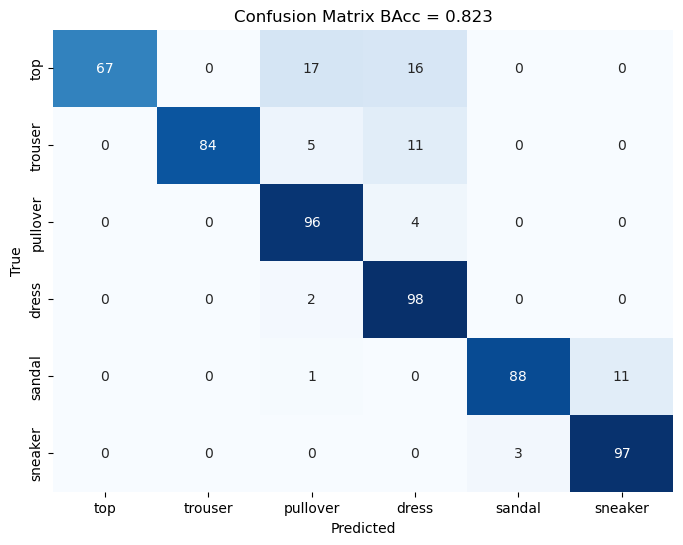

In [60]:
conf_matrix = confusion_matrix(valid_y, pred_y)

# Display the confusion matrix using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['top', 'trouser', 'pullover', 'dress', 'sandal', 'sneaker'],
            yticklabels=['top', 'trouser', 'pullover', 'dress', 'sandal', 'sneaker'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix BAcc = 0.823')
plt.show()

In [63]:
### Leaderboard
# Load the dataset of interest
datadir = os.path.abspath('data_fashion')
x_NF = np.loadtxt(os.path.join(datadir, 'x_test.csv'), 
                  delimiter=',', 
                  skiprows=1)

N = x_NF.shape[0]
normed_test_x = sklearn.preprocessing.normalize(x_NF, norm = 'l1', axis = 1)
yhat_pred_num = best_mlp.predict(x_NF)
print(yhat_pred_num)
yhat_pred = yhat_pred_num.astype(str)
names = ['dress', 'pullover', 'top', 'trouser', 'sandal', 'sneaker']

yhat_pred[yhat_pred_num == 3] = names[0] # dress
yhat_pred[yhat_pred_num == 2] = names[1] # pullover
yhat_pred[yhat_pred_num == 0] = names[2] # top
yhat_pred[yhat_pred_num == 1] = names[3] # trouser
yhat_pred[yhat_pred_num == 5] = names[4] # sandal
yhat_pred[yhat_pred_num == 7] = names[5] # sneaker

print(yhat_pred)
np.savetxt('yhat_test_part2.txt', yhat_pred, delimiter='\n', fmt='%s')

[0 1 2 2 7 2 5 0 3 5 3 2 1 5 7 1 7 7 7 1 3 3 2 0 2 0 3 3 2 7 2 2 3 0 3 5 7
 1 0 7 2 7 3 5 7 1 1 1 2 1 3 2 2 7 7 7 3 7 7 2 7 2 7 5 7 3 2 7 7 0 2 7 7 0
 5 7 0 7 0 3 7 7 3 3 7 3 2 2 7 0 1 3 7 7 1 7 3 3 5 7 7 7 2 0 7 2 2 0 2 5 7
 1 7 1 5 7 0 7 1 2 0 2 2 0 2 5 5 2 1 2 7 1 5 2 2 5 7 7 3 2 7 7 1 5 2 7 0 2
 1 5 7 7 0 2 5 3 3 1 2 3 3 2 2 2 7 2 2 7 2 5 5 7 2 3 1 2 2 2 1 1 3 3 1 7 2
 5 2 0 7 7 7 7 1 7 7 0 2 2 2 5 3 5 7 7 1 2 7 3 7 7 5 5 0 2 0 7 5 5 2 2 0 7
 7 2 7 7 2 0 2 2 7 2 7 7 5 1 2 5 5 7 3 7 3 5 0 0 2 7 5 7 3 5 0 0 5 7 7 5 5
 0 0 1 0 2 3 1 2 5 3 2 7 1 2 0 7 7 5 1 2 3 3 5 5 5 3 2 7 1 5 2 7 5 3 7 7 7
 7 7 1 7 2 2 1 7 1 7 1 2 2 3 2 5 7 3 2 0 3 2 5 2 3 2 5 5 3 7 1 7 2 1 7 2 7
 3 5 7 7 1 7 0 2 2 3 7 7 2 7 7 5 7 1 1 7 5 0 2 3 7 2 0 2 5 2 7 7 1 1 3 7 5
 7 5 7 0 7 0 1 7 7 7 7 1 3 5 7 3 7 5 1 3 2 5 5 1 3 7 3 7 2 3 1 1 7 7 5 7 7
 7 3 7 7 7 1 3 7 0 3 0 1 0 7 2 7 7 7 1 3 7 7 7 0 1 7 5 7 7 1 2 0 1 7 0 3 5
 1 7 7 1 0 7 7 7 0 2 7 0 5 7 2 7 7 3 1 7 1 3 7 1 7 7 2 1 5 0 7 3 2 7 1 3 5
 2 3 1 7 1 3 3 1 7 5 5 5 